# Assignment 3: Variational Autoencoders (VAEs)
## DS552 – Generative AI

This assignment studies Variational Autoencoders from both a theoretical
and practical perspective. The goal is to understand probabilistic latent
spaces and apply VAEs to image datasets using convolutional architectures.


## Theory Questions

### Q1: Why is the KL Divergence term important in the VAE loss function?

The KL Divergence element of the VAE loss function performs essential work to regulate the distribution of latent space elements. The system requires encoded latent vectors to follow standard normal distribution patterns because this method helps maintain a consistent and important latent space structure. The model achieves better generalization results because the system prevents overfitting and creates a continuous representation of data. The regularization creates a pathway to sample from the learned distribution which enables smooth transitions between latent space points resulting in authentic data transformations.



### Q2: How does the reparameterization trick enable backpropagation?

The reparameterization method must be implemented to enable backpropagation through the stochastic layers of a VAE model. The system achieves efficient gradient calculation through its design which separates two components: the random sampling process and the network parameters. The method expresses random sampling as a deterministic function with extrinsic unpredictability, rather than sampling directly from the latent distribution. The network achieves end-to-end differentiability because the sampling process allows gradient propagation throughout the entire system. The VAE can be trained successfully through conventional gradient optimization methods.


### Q3: Why does a VAE use a probabilistic latent space?

To better capture the underlying structure of the data, a VAE employs a probabilistic latent space rather than a fixed latent space. Probability can be used to express data uncertainty, strengthening the model and increasing its ability to produce a variety of results. Additionally, this method guarantees that the latent space is meaningful and continuous, facilitating seamless transitions between various data points. Furthermore, by preventing overfitting to particular cases and allowing the model to produce fresh, realistic data, a probabilistic latent space improves generalization. Additionally, it facilitates better handling of input data changes, increasing the VAE's adaptability to various distributions.


### Q4: What role does KL Divergence play in ensuring a smooth latent space?

The smooth development of a latent space requires KL Divergence because it helps establish structured boundaries between different areas of the space. The method prevents latent space clusters from developing by enforcing encoded representations to overlap instead of maintaining their separate identities. The model handles data interpolation between multiple samples because the overlap guarantees the model can create smooth transitions between different points. KL Divergence ensures that any latent space sample will produce authentic results which maintain uniformity across the entire dataset.

Coding Tasks:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

LOADING CIFAR-10 DATASET

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)


100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]


In [5]:
class FCVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [6]:
def vae_loss(x, x_hat, mu, logvar):
    recon = nn.functional.binary_cross_entropy(
        x_hat, x.view(x_hat.shape), reduction="sum"
    )
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl


TRAIN FC VAE

In [7]:
fc_vae = FCVAE().to(device)
optimizer = optim.Adam(fc_vae.parameters(), lr=1e-3)

for epoch in range(3):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = fc_vae(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 1996.4202
Epoch 2, Loss: 1944.4936
Epoch 3, Loss: 1920.0390


CONVOLUTIONAL VAE

In [8]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64*8*8, latent_dim)
        self.fc_logvar = nn.Linear(64*8*8, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64*8*8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.decoder_input(z).view(-1, 64, 8, 8)
        x_hat = self.decoder(h_dec)
        return x_hat, mu, logvar


In [16]:
conv_vae = ConvVAE().to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

for epoch in range(15):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = conv_vae(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 1912.3492
Epoch 2, Loss: 1843.4283
Epoch 3, Loss: 1833.5523
Epoch 4, Loss: 1829.8862
Epoch 5, Loss: 1827.7036
Epoch 6, Loss: 1825.9306
Epoch 7, Loss: 1824.5502
Epoch 8, Loss: 1823.6835
Epoch 9, Loss: 1822.8144
Epoch 10, Loss: 1822.0544
Epoch 11, Loss: 1821.6329
Epoch 12, Loss: 1821.3614
Epoch 13, Loss: 1820.9749
Epoch 14, Loss: 1820.5259
Epoch 15, Loss: 1820.2608


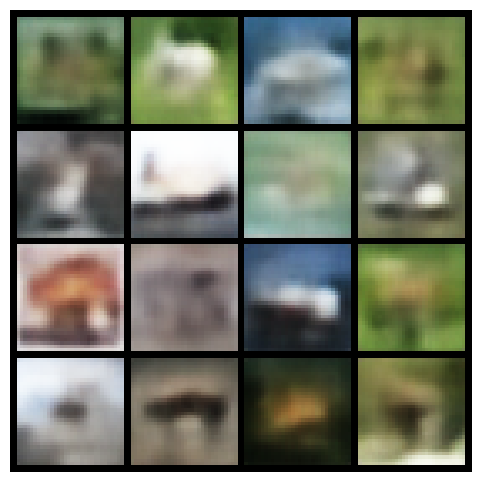

In [17]:
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.to(device)[:16]
    recon, _, _ = conv_vae(x)

    grid = make_grid(recon.cpu(), nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")


TASK 2

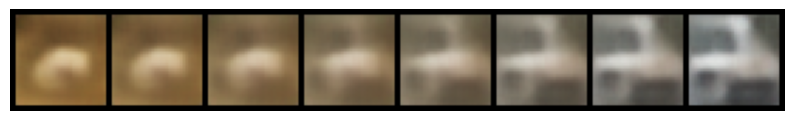

In [18]:
with torch.no_grad():
    x1, _ = train_dataset[0]
    x2, _ = train_dataset[1]

    x1 = x1.unsqueeze(0).to(device)
    x2 = x2.unsqueeze(0).to(device)

    _, mu1, _ = conv_vae(x1)
    _, mu2, _ = conv_vae(x2)

    images = []
    for alpha in torch.linspace(0, 1, 8):
        z = mu1 * (1 - alpha) + mu2 * alpha
        out = conv_vae.decoder(
            conv_vae.decoder_input(z).view(-1, 64, 8, 8)
        )
        images.append(out)

    grid = make_grid(torch.cat(images), nrow=8)
    plt.figure(figsize=(10,3))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")


NTERPOLATION OBSERVATION

The interpolation results show smooth transitions between two images,
indicating that the VAE has learned a continuous and structured latent space.


TASK 3

In [14]:
fashion_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

fashion_loader = DataLoader(
    fashion_data,
    batch_size=128,
    shuffle=True
)


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.75MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 50.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


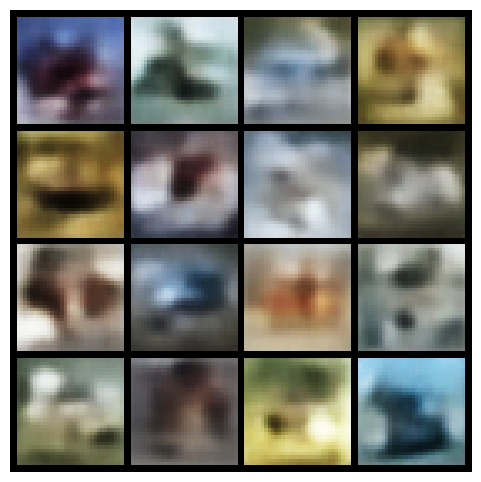

In [19]:
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = conv_vae.decoder(
        conv_vae.decoder_input(z).view(-1, 64, 8, 8)
    )

    grid = make_grid(samples.cpu(), nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
